# Anomaly Detection
In this exercise, you will implement the anomaly detection algorithm and
apply it to detect failing servers on a network.

In [18]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
import scipy.linalg as linalg


Visualizing example dataset for outlier detection.



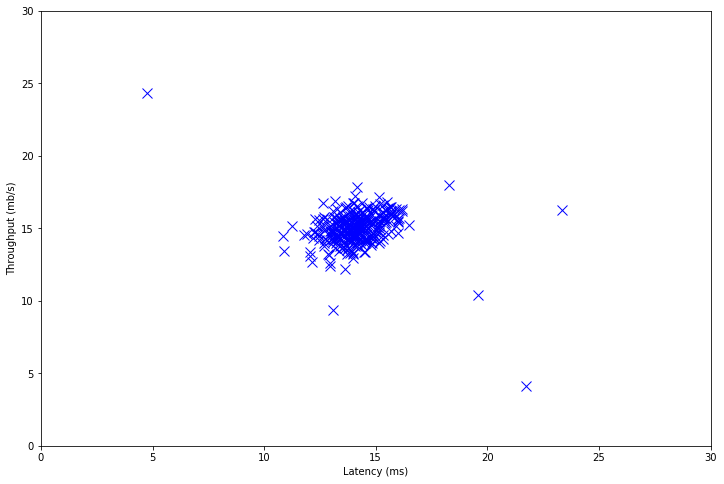

In [8]:
## ================== Part 1: Load Example Dataset  ===================
#  We start this exercise by using a small dataset that is easy to
#  visualize.
#
#  Our example case consists of 2 network server statistics across
#  several machines: the latency and throughput of each machine.
#  This exercise will help us find possibly faulty (or very fast) machines.
#

print('Visualizing example dataset for outlier detection.\n');

#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment
mat = scipy.io.loadmat('data/ex8/ex8data1.mat')
X = mat["X"]
Xval = mat["Xval"]
yval = mat["yval"].flatten()

#  Visualize the example dataset
plt.figure(figsize=(12,8))
plt.plot(X[:, 0], X[:, 1], 'bx', markersize=10, markeredgewidth=1)
plt.axis([0,30,0,30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show(block=False)


In [13]:
def estimateGaussian(X):
    #ESTIMATEGAUSSIAN This function estimates the parameters of a 
    #Gaussian distribution using the data in X
    #   [mu sigma2] = estimateGaussian(X), 
    #   The input X is the dataset with each n-dimensional data point in one row
    #   The output is an n-dimensional vector mu, the mean of the data set
    #   and the variances sigma^2, an n x 1 vector
    # 

    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the mean of the data and the variances
    #               In particular, mu(i) should contain the mean of
    #               the data for the i-th feature and sigma2(i)
    #               should contain variance of the i-th feature.
    #

    # estimating mu - at this point it is an n-column vector
    # mu = (1/m)*sum(X,1);
    mu = np.mean(X, axis=0)
    # turn into n-rows vector
    mu = mu.T

    # estimating sigma^2 = std.dev.
    # normalizes with 1/N, instead of with 1/(N-1) in formula std (x) = 1/(N-1) SUM_i (x(i) - mean(x))^2 
    # i.e. degrees of freedom = 0 (by default)
    sigma2 = np.var(X, axis=0)

    # turn into n-rows vector
    sigma2 = sigma2.T
    return mu, sigma2


def multivariateGaussian(X, mu, sigma2):
    #MULTIVARIATEGAUSSIAN Computes the probability density function of the
    #multivariate gaussian distribution.
    #    p = MULTIVARIATEGAUSSIAN(X, mu, sigma2) Computes the probability 
    #    density function of the examples X under the multivariate gaussian 
    #    distribution with parameters mu and sigma2. If sigma2 is a matrix, it is
    #    treated as the covariance matrix. If sigma2 is a vector, it is treated
    #    as the \sigma^2 values of the variances in each dimension (a diagonal
    #    covariance matrix)
    #

    k = len(mu)

    # turns 1D array into 2D array
    if sigma2.ndim == 1:
        sigma2 = np.reshape(sigma2, (-1,sigma2.shape[0]))

    if sigma2.shape[1] == 1 or sigma2.shape[0] == 1:
        sigma2 = linalg.diagsvd(sigma2.flatten(), len(sigma2.flatten()), len(sigma2.flatten()))

    # mu is unrolled (and transposed) here
    X = X - mu.reshape(mu.size, order='F').T

    p = np.dot(np.power(2 * np.pi, - k / 2.0), np.power(np.linalg.det(sigma2), -0.5) ) * \
        np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2)) * X, axis=1))

    return p
def visualizeFit(X, mu, sigma2):
    #VISUALIZEFIT Visualize the dataset and its estimated distribution.
    #   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
    #   probability density function of the Gaussian distribution. Each example
    #   has a location (x1, x2) that depends on its feature values.
    #

    X1,X2 = np.meshgrid(np.arange(0, 35.1, 0.5), np.arange(0, 35.1, 0.5))
    Z = multivariateGaussian(np.column_stack((X1.reshape(X1.size, order='F'), X2.reshape(X2.size, order='F'))), mu, sigma2)
    Z = Z.reshape(X1.shape, order='F')

    plt.plot(X[:, 0], X[:, 1],'bx', markersize=13, markeredgewidth=1)
    # plt.scatter(X[:, 0], X[:, 1], s=150, c='b', marker='x', linewidths=1)

    # Do not plot if there are infinities
    if (np.sum(np.isinf(Z)) == 0):
        plt.contour(X1, X2, Z, np.power(10,(np.arange(-20, 0.1, 3)).T))


Visualizing Gaussian fit.



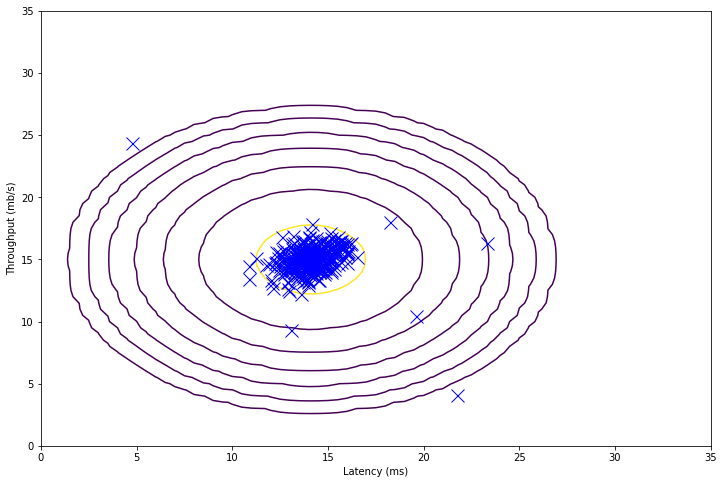

In [14]:
## ================== Part 2: Estimate the dataset statistics ===================
#  For this exercise, we assume a Gaussian distribution for the dataset.
#
#  We first estimate the parameters of our assumed Gaussian distribution, 
#  then compute the probabilities for each of the points and then visualize 
#  both the overall distribution and where each of the points falls in 
#  terms of that distribution.
#
print('Visualizing Gaussian fit.\n')

#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
plt.close()
plt.figure(figsize=(12,8))
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show(block=False)

In [15]:
def selectThreshold(yval, pval):
    #SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
    #outliers
    #   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    #   threshold to use for selecting outliers based on the results from a
    #   validation set (pval) and the ground truth (yval).
    #

    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        
        # ====================== YOUR CODE HERE ======================
        # Instructions: Compute the F1 score of choosing epsilon as the
        #               threshold and place the value in F1. The code at the
        #               end of the loop will compare the F1 score for this
        #               choice of epsilon and set it to be the best epsilon if
        #               it is better than the current choice of epsilon.
        #               
        # Note: You can use predictions = (pval < epsilon) to get a binary vector
        #       of 0's and 1's of the outlier predictions

        # make anomaly predictions based on which values of pval are less than epsilon
        #   i.e. which examples from the cross-validation set have a very low p(x)
        cvPredictions = pval < epsilon

        # calculate F1 score, starting by calculating true positives(tp)
        # false positives (fp) and false negatives (fn)

        # true positives is the intersection between 
        #   our positive predictions (cvPredictions==1) and positive ground truth values (yval==1)
        tp = np.sum(np.logical_and((cvPredictions==1), (yval==1)).astype(float))

        # false positives are the ones we predicted to be true (cvPredictions==1) but weren't (yval==0)
        fp = np.sum(np.logical_and((cvPredictions==1), (yval==0)).astype(float))
        
        # false negatives are the ones we said were false (cvPredictions==0) but which were true (yval==1)
        fn = np.sum(np.logical_and((cvPredictions==0), (yval==1)).astype(float))

        # compute precision, recall and F1
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = (2*precision*recall)/(precision+recall)

        # =============================================================

        if F1 > bestF1:
           bestF1 = F1
           bestEpsilon = epsilon

    return bestEpsilon, bestF1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)



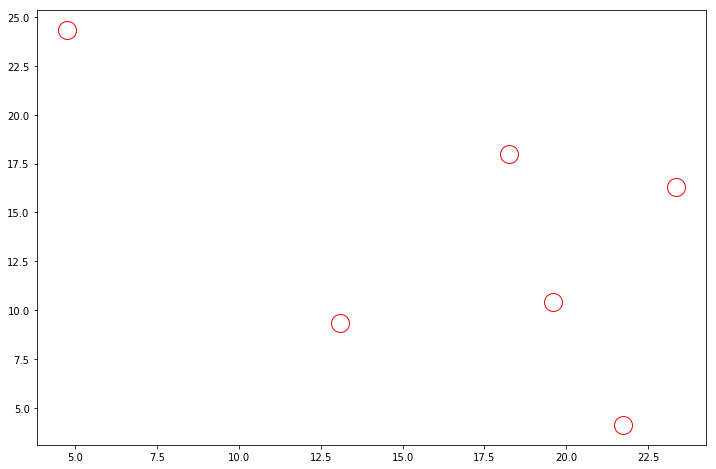

In [21]:
## ================== Part 3: Find Outliers ===================
#  Now you will find a good epsilon threshold using a cross-validation set
#  probabilities given the estimated Gaussian distribution
# 

pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: {:e}'.format(epsilon))
print('Best F1 on Cross Validation Set:  {:f}'.format(F1))
print('   (you should see a value epsilon of about 8.99e-05)\n')

# Find the outliers in the training set and plot the
outliers = p < epsilon
# interactive graphs
plt.ion()
plt.figure(figsize=(12,8))
#  Draw a red circle around those outliers
# plt.scatter(X[outliers, 0], X[outliers, 1], s=325, facecolors='none', edgecolors='r')
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', linewidth=2, markersize=18, fillstyle='none', markeredgewidth=1)
plt.show(block=False)

In [22]:
## ================== Part 4: Multidimensional Outliers ===================
#  We will now use the code from the previous part and apply it to a 
#  harder problem in which more features describe each datapoint and only 
#  some features indicate whether a point is an outlier.
#

#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
mat = scipy.io.loadmat('data/ex8/ex8data2.mat')
X = mat["X"]
Xval = mat["Xval"]
yval = mat["yval"].flatten()

#  Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: {:e}'.format(epsilon))
print('Best F1 on Cross Validation Set:  {:f}'.format(F1))
print('# Outliers found: {:d}'.format(np.sum((p < epsilon).astype(int))))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Outliers found: 117


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
